# Expériences à mener

- Regarder ce qu'apprend l'opérateur dynamique
- Comparer avec d'autres modèles pour lesquels le bruit du modèle dépend des observations précdentes
- Rajouter un terme au moindre carré pour la moyenne
- loss_AE très mauvais
- La covariance ne varie pas assez vite
- Faire les probabilités de dépassement à un certain seuil
- Faire varier les conditions initiales de la covariance, voire ajouter un réseau qui donne la condition initiale
- Quel est l'intérêt d'avoir une composante HR et LR dans un cas comme celui-ci?
- Entraîner l'AE tout seul pour voir
- Premières expériences très bonnes
- Essayer sans NNLR pour l'AE


# Constatation

Lorsque l'on introduit une erreur au moindre carré supplémentaire, on obtient de bonnes reconstructions pour la moyenne.

# Récupération des données

In [2]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from scipy.stats import t
print(torch.cuda.device_count())
print(os.getcwd())
import statsmodels

1
/home/VM-Nicolas-Lafon/Project_distribution_EVT


In [1]:
ncfile = Dataset('lightning_logs/version_149/test.nc')
print(ncfile)
mu = ncfile['mean_pred']
cov = ncfile['cov_pred']
init = ncfile['inits']
target = ncfile['targets']


NameError: name 'Dataset' is not defined

# Première visualisation

0.84980726
-0.2550162
1.5402559
Moyenne de la covariance pour chaque pas de temps
[1.1803018  1.2370434  0.9602899  1.2167343  1.4289356  1.140601
 1.284259   0.21837811 0.13601527 0.13227023]
0.02006823198876179
0.020100502512562814


0.02012477359629704

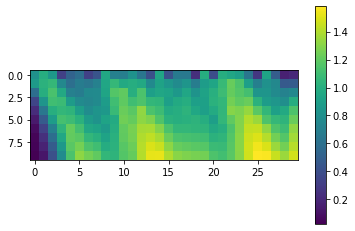

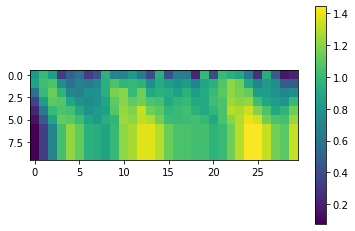

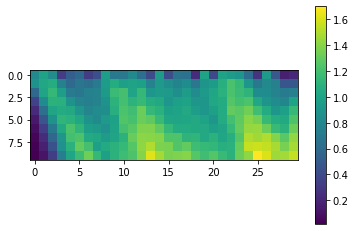

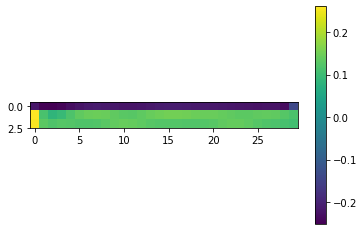

In [26]:
plt.figure()
plt.imshow(mu[100,:,:])
plt.colorbar()
plt.figure()
plt.imshow(init[100,:,:])
plt.colorbar()
plt.figure()
plt.imshow(target[100,:,:])
plt.colorbar()
plt.figure()
plt.imshow(np.abs(cov[100,7:10,:])
plt.colorbar()
print(np.mean(cov))
print(np.min(cov))
print(np.max(cov))
print("Moyenne de la covariance pour chaque pas de temps")
print(np.mean(np.mean(np.abs(cov),0),1))
print(1/49.83)
print(1/49.75)
1/49.69

Variance pour chaque pas de temps
[1.1274016e-06 1.1263548e-06 1.2438443e-06 1.1008179e-06 1.0464897e-06
 1.1554895e-06 1.1317278e-06 2.0576459e-03 3.8579893e-03 5.8062249e-03]
Variance pour la prévision avec la persistance
[0.00583915 0.01906151 0.03890559]


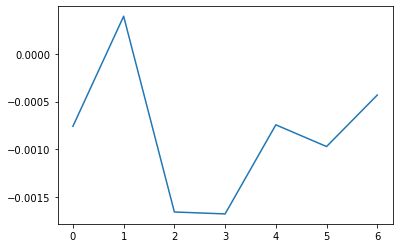

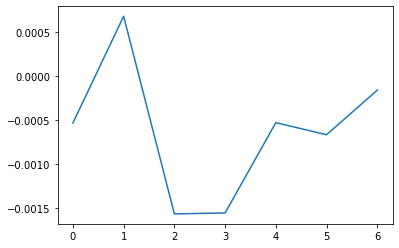

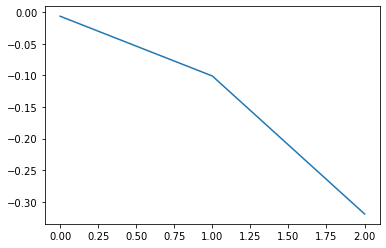

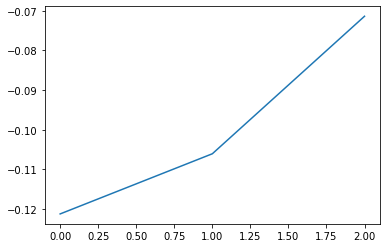

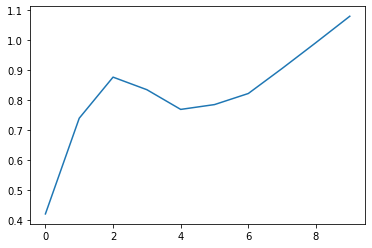

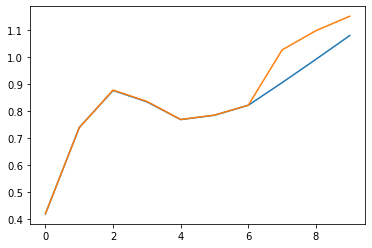

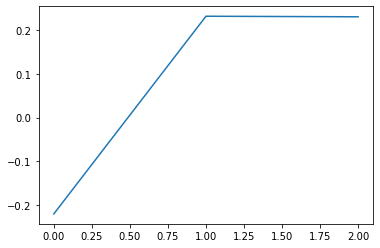

In [27]:

plt.plot(init[10,0:7,10]-target[10,0:7,10])
plt.figure()
plt.plot(mu[10,0:7,10]-target[10,0:7,10])
plt.figure()
plt.plot(init[10,7:10,11]-target[10,7:10,11])
plt.figure()
plt.plot(mu[10,7:10,10]-target[10,7:10,10])
plt.figure()
plt.plot(mu[10,:,10])
plt.figure()
plt.plot(mu[10,:,10])
plt.plot(target[10,:,10])
plt.figure()
plt.plot(cov[0,7:10,0])

print("Variance pour chaque pas de temps")
print(np.mean(np.mean((mu[:,:,:]-target[:,:,:])**2,0),1))

print("Variance pour la prévision avec la persistance")
print(np.mean(np.mean((init[:,7:10,:]-target[:,7:10,:])**2,0),1))

# Comparaison entre la covariance réel et estimé

(200, 10, 30)


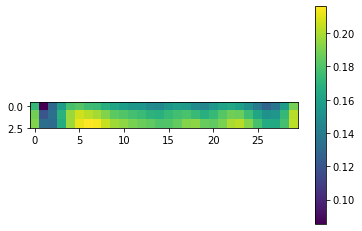

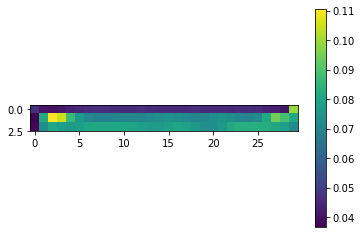

In [28]:
#Cas du modèle multiplicatif

DX = 30
indice = 20
Model_noise =0.02
Obs_noise = 0.001
print(target.shape)
real_cov = torch.zeros(10,30)
real_cov[0:7,:]=Obs_noise
for i in range(7,10):
    for j in range(30):
        real_cov[i,j] = (0.6*real_cov[i-1,j])**2+(0.4*real_cov[i-1,(j-1)%DX])**2+(0.2*real_cov[i-1 , (j+1)%DX])**2+(0.1*real_cov[i-1,(j+2)%DX])**2+(0.05*real_cov[i-1, (j-2)%DX])**2
        real_cov[i,j] += (target[indice,i-1,j]**2+target[indice,i-1,(j-1)%DX]**2)*(0.02**2)
        real_cov[i,j] =np.sqrt(real_cov[i,j])
real_cov[7:10,:] = torch.sqrt(real_cov[7:10,:])


estimated_cov = 1/np.abs(cov[indice,:,:])/100


plt.figure()
plt.imshow(real_cov[7:10,:])
plt.colorbar()
plt.figure()
plt.imshow(estimated_cov[7:10,:])
plt.colorbar()

# Opérateur dynamique

In [159]:
from models import Gradient_img, LitModel
import torch

In [174]:
ckpt_path ='Res_Update/modelsum-Exp2-epoch=140-val_loss=-3.78.ckpt'
lit_cls = LitModel
mod = lit_cls.load_from_checkpoint(ckpt_path, 
                                                    mean_Tr=0, 
                                                    std_Tr = 0
                                                    )

Phi_r(
  (encoder): Encoder(
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (convTr): ConvTranspose2d(10, 10, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (NNLR): Sequential(
      (0): BiLinUnit(
        (conv1): Conv2d(10, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
        (conv2): Conv2d(100, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv3): Conv2d(100, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin0): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin1): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bilin2): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (NNHR): Sequential(
      (0): BiLinUnit(
        (conv1): Conv2d(10, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)


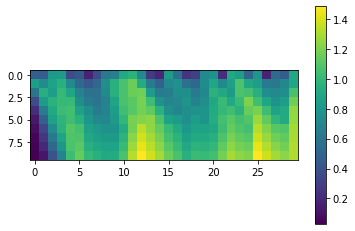

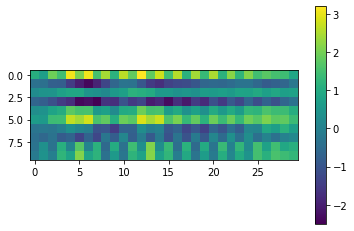

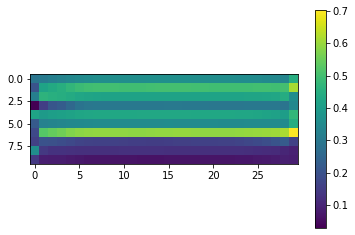

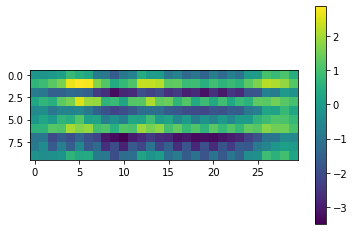

In [176]:
print(mod.model.phi_r)
ex= torch.zeros(1,10,30,2)
print(ex.shape)
ex[0,:,:,0] = torch.Tensor(mu[50,:,:])
ex[0,:,:,1] = torch.abs(torch.Tensor(cov[50,:,:]))
i0 = mod.model.phi_r(ex).detach().numpy()
plt.figure()
plt.imshow(ex[0,:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(i0[0,:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(ex[0,:,:,1])
plt.colorbar()
plt.figure()
plt.imshow(i0[0,:,:,1])
plt.colorbar()

print("Différence moyenne entre phi et la sortie")
tot = torch.zeros(200,10,30,2)

 # Scoring rules

On s'intéresse aux p-scores : 

In [180]:
def logarithmic_scores(t,mu,sig):
    return(0.5*(((t-mu)*sig*100)**2)-np.log(sig*100)+0.5*np.log(2*np.pi))


scores = logarithmic_scores(target[:,:,:],mu[:,:,:],cov[:,:,:])
0.5*np.log(2*np.pi)
np.log(1000)

<ipython-input-180-d33daf4b6f52>:2: RuntimeWarning: invalid value encountered in log
  return(0.5*(((t-mu)*sig*100)**2)-np.log(sig*100)+0.5*np.log(2*np.pi))


6.907755278982137

In [181]:
scores.shape
np.mean(np.mean(scores[:,:,:],0),1)

masked_array(data=[-2.6390120544433597, -2.9461039123535153, --,
                   -2.424281347866716, -2.82837158203125,
                   -2.6280511474609374, -3.116460174560547,
                   -1.816624298095703, -0.9442267634073891,
                   -1.6997953796386718],
             mask=[False, False,  True, False, False, False, False, False,
                   False, False],
       fill_value=1e+20)

In [164]:
def almost_entropy_score(t,mu,sig):
    res = -1/(np.sqrt((2*np.pi))*sig)*np.exp(-0.5*(t-mu)**2/(sig**2))
    res= res * logarithmic_scores(t,mu,sig)
    return res

scores = almost_entropy_score(target[:,:,:],mu[:,:,:],cov[:,:,:])

<ipython-input-162-0825ec670fc1>:2: RuntimeWarning: invalid value encountered in log
  return(0.5*(((t-mu)*sig)**2)-np.log(sig)+0.5*np.log(2*np.pi))


In [165]:
scores.shape
np.mean(np.mean(scores[:,:,:],0),1)

masked_array(data=[-0.2556015726725261, -0.22793784713745116,
                   -0.40171158790588385, -0.23778729756673175,
                   -0.15720201269785564, -0.27570986429850264,
                   -0.2077825158437093, --, -8.078142354329426,
                   -7.865418874104818],
             mask=[False, False, False, False, False, False, False,  True,
                   False, False],
       fill_value=1e+20)

Probabilité de dépassement à un certain seuil


In [169]:
print(np.sum(target[:,7,10]>1.2))
p_dep = 53/200/30
print(p_dep)


26
0.008833333333333334


In [167]:
from scipy.stats import norm
Res= torch.zeros(200)
for i in range(200):
        Res[i] = norm.cdf((0.25-mu[i,7,10])*(100*cov[i,7,10]))

In [170]:
Ind = np.where(target[:,7,10]>1.2)
print(1-Res[Ind])
Ind_ = np.where(target[:,7,10]<1.2) 
print(1-Res[Ind_])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,